## Access Vessel Air Sea Flux Sst Meteo Realtime data in Parquet
A jupyter notebook to show how to access and plot the AODN vessel_air_sea_flux_sst_meteo_realtime dataset available as a [Parquet](https://parquet.apache.org) dataset on S3

In [1]:
dataset_name = "vessel_air_sea_flux_sst_meteo_realtime"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os


def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    os.system('uv pip install --system -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')
else:
    os.system('uv venv')
    os.system('uv pip install -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')

Using Python 3.12.4 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python3
Creating virtualenv at: .venv
Activate with: source .venv/bin/activate
Audited 128 packages in 444ms


In [3]:
import requests
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [4]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, \
    get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds

import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

platform_code: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'platform_code')
print(list(unique_partition_value)) 

['VLHJ', 'VLMJ', 'VMIC', 'ZMFR', 'VNAA']
CPU times: user 21.3 ms, sys: 3.57 ms, total: 24.8 ms
Wall time: 25 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

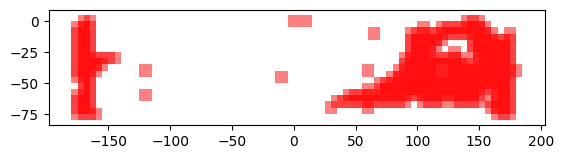

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [9]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2008, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2024, 1, 1, 0, 0, tzinfo=datetime.timezone.utc))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

Error decoding JSON for key b'TEMP': Expecting ',' delimiter: line 1 column 356 (char 355)
Problematic JSON string: {"type": "float", "long_name": "sea temperature", "units": "celsius", "instrument": "Seabird SBE 38 (s/n 1061)", "observation_type": "measured", "distance_from_bow": -33.06100082397461, "centerline_offset": 0.8999999761581421, "sensor_depth": 5.900000095367432, "comment": "The height attribute refers to the depth of the seawater intake below the vessel"s Summer Water Line when the port drop keel is flush with the ship"s hull. However, the actual depth of the seawater intake is height-KEEL_EXT. The KEEL_EXT can vary throughout a cruise. For KEEL_EXT=0 the SBE 38 sensor will not operate.", "standard_name": "sea_surface_temperature", "ancillary_variables": "TEMP_quality_control"}


{'timestamp': {'type': 'int64'},
 'polygon': {'type': 'string'},
 'filename': {'type': 'string'},
 'platform_code': {'type': 'string'},
 'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0,
  'valid_max': 90000.0,
  'comment': 'Relative julian days with decimal part as parts of the day',
  'ancillary_variables': 'TIME_quality_control'},
 'LATITUDE': {'type': 'float',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'instrument': 'Seapath 330+ position and reference unit',
  'observation_type': 'measured',
  'standard_name': 'latitude',
  'axis': 'Y',
  'valid_min': -90,
  'valid_max': 90,
  'reference_datum': 'geographical coordinates, WGS84',
  'ancillary_variables': 'LATITUDE_quality_control'},
 'LONGITUDE': {'type': 'float',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'instrument': 'Seapath 330+ position and reference unit',
  'observation_type': 'measured',
  'standard_name': 'longitude',
  'axis':

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2009-08-01', date_end='2010-11-01')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-50, lat_max=10, lon_min=80, lon_max=160)


filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5509855 entries, 0 to 5509854
Data columns (total 73 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   filename                       object        
 1   TIME                           datetime64[ns]
 2   LATITUDE                       float32       
 3   LONGITUDE                      float32       
 4   PL_HD                          float32       
 5   PL_CRS                         float32       
 6   PL_SPD                         float32       
 7   PL_WDIR                        float32       
 8   PL_WSPD                        float32       
 9   WDIR                           float32       
 10  WSPD                           float32       
 11  PL_WDIR_2                      float32       
 12  PL_WSPD_2                      float32       
 13  WDIR_2                         float32       
 14  WSPD_2                         float32       
 15  ATMP           

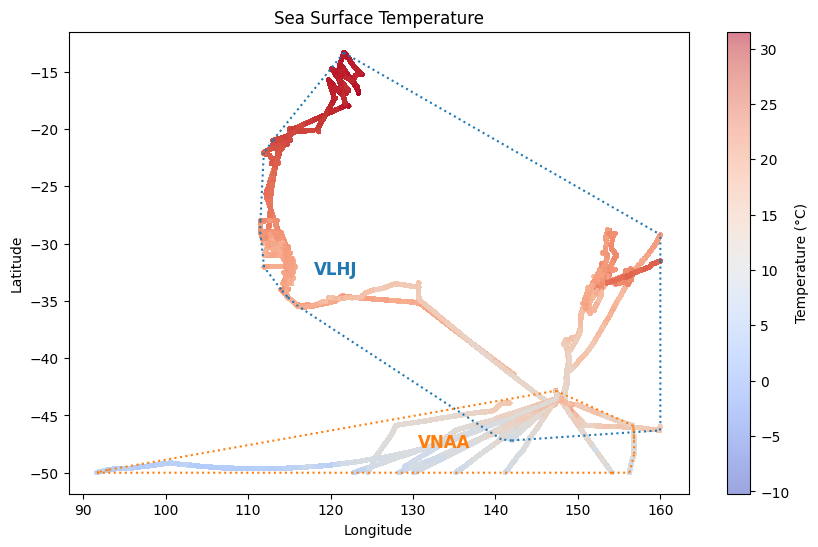

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from itertools import cycle

# function to plot the convex hull around the vessel's data points
def draw_convex_hull(ax, points, label, color):
    hull = ConvexHull(points)
    # Plot the convex hull as a dotted polygon
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], linestyle=':', color=color, linewidth=1.5)
    
    centroid = np.mean(points[hull.vertices], axis=0)
    ax.text(centroid[0], centroid[1], label, fontsize=12, weight='bold', ha='center', color=color)

plt.figure(figsize=(10, 6))

# Adjusting alpha to reduce darkness
sc = plt.scatter(df['LONGITUDE'], df['LATITUDE'], c=df['TEMP'], cmap='coolwarm', s=10, edgecolor='none', alpha=0.5)

cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)')

# Labels and titles
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Surface Temperature')

# assign different colors to each platform
color_cycle = cycle(plt.cm.tab10.colors)  # Use a colormap with 10 distinct colors

# Group the data by platform_code
unique_vessels = df['platform_code'].unique()

# Draw convex hulls for each unique vessel
for vessel in unique_vessels:
    df_vessel = df[df['platform_code'] == vessel]
    
    # Combine the longitude and latitude into a set of points
    points = df_vessel[['LONGITUDE', 'LATITUDE']].to_numpy()
    
    # Only draw convex hull if there are enough points
    if len(points) >= 3:
        color = next(color_cycle)  # Get the next color from the color cycle
        draw_convex_hull(plt.gca(), points, vessel, color)

plt.show()


## Create a TIME and scalar/number filter

In [14]:
filter_time = create_time_filter(parquet_ds, date_start='2022-07-12', date_end='2023-02-05')

expr_1 = pc.field('platform_code') == 'VLMJ'
filter = expr_1 & filter_time

In [15]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4443520 entries, 0 to 4443519
Data columns (total 73 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   filename                       object        
 1   TIME                           datetime64[ns]
 2   LATITUDE                       float32       
 3   LONGITUDE                      float32       
 4   PL_HD                          float32       
 5   PL_CRS                         float32       
 6   PL_SPD                         float32       
 7   PL_WDIR                        float32       
 8   PL_WSPD                        float32       
 9   WDIR                           float32       
 10  WSPD                           float32       
 11  PL_WDIR_2                      float32       
 12  PL_WSPD_2                      float32       
 13  WDIR_2                         float32       
 14  WSPD_2                         float32       
 15  ATMP           

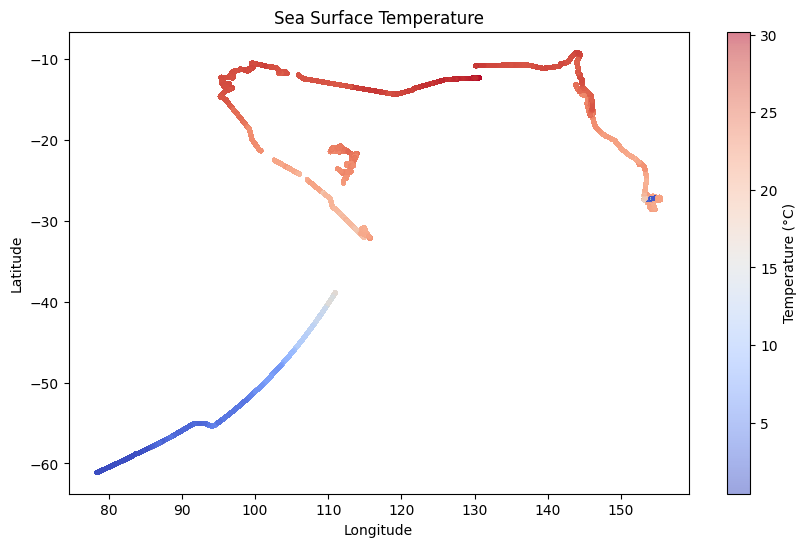

In [16]:
plt.figure(figsize=(10, 6))

sc = plt.scatter(df['LONGITUDE'], df['LATITUDE'], c=df['TEMP'], cmap='coolwarm', s=10, edgecolor='none', alpha=0.5)

# Adding colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)')

# Labels and titles
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Surface Temperature')

plt.show()